## **Notebook Imports**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import optuna

import tensorflow as tf

## **Loading Data**

In [6]:
data0 = pd.read_csv('Data/Ecommerce Customers.csv')
data0.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\r\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\r\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\r\nCobbborough,...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\r\nPort Jason, OH 22070-...",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\r\nPort Jacobville, PR...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [7]:
print('Number of rows:', data0.shape[0])
print('Number of columns:', data0.shape[1])

Number of rows: 500
Number of columns: 8


## **Checking For Missing Values**

In [8]:
data0.isna().sum()

Email                   0
Address                 0
Avatar                  0
Avg. Session Length     0
Time on App             0
Time on Website         0
Length of Membership    0
Yearly Amount Spent     0
dtype: int64

There are no missing values in our dataset

`Email`, `Address` and `Avatar` column won't be much useful in our analysis, therefore I will just drop them

In [9]:
data1 = data0.drop(['Email', 'Address', 'Avatar'], axis=1)

In [10]:
data1.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


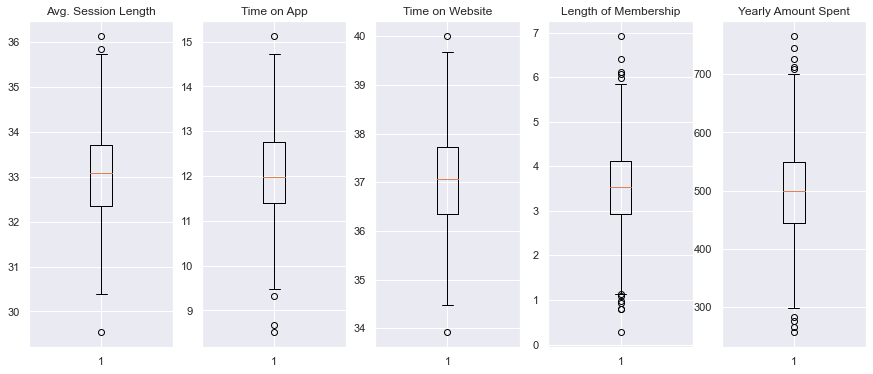

In [11]:
figures, (fig1, fig2, fig3, fig4, fig5) = plt.subplots(1, 5, figsize=(15,6))
fig1.boxplot(data1['Avg. Session Length'])
fig1.set_title('Avg. Session Length')
fig2.boxplot(data1['Time on App'])
fig2.set_title('Time on App')
fig3.boxplot(data1['Time on Website'])
fig3.set_title('Time on Website')
fig4.boxplot(data1['Length of Membership'])
fig4.set_title('Length of Membership')
fig5.boxplot(data1['Yearly Amount Spent'])
fig5.set_title('Yearly Amount Spent')

plt.show()

## **EDA**

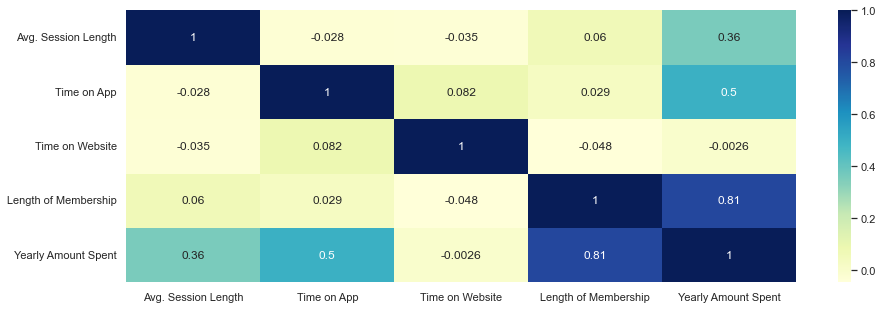

In [41]:
plt.figure(figsize= (15, 5))
sns.heatmap(data1.corr(), annot= True, cmap='YlGnBu')
plt.show()

`Time on Website` doesn't seem to be a useful feature. Also, `length of membership` seems to correlated with yearly amount spent

In [42]:
data1 = data1.drop('Time on Website', axis=1)

Let us also check the distribution of our target variable

0.161

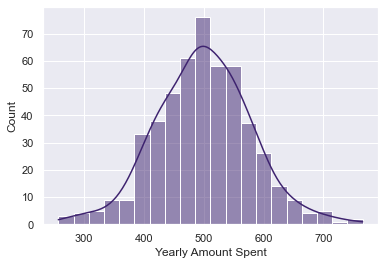

In [43]:
sns.histplot(data1['Yearly Amount Spent'], kde= True, color = '#3e236f');
normaltest(data1['Yearly Amount Spent']).pvalue.round(3)

Distribution of `Yearly Amount Spent` seems to be normal, so I don't think there is a need to apply log transformation to it

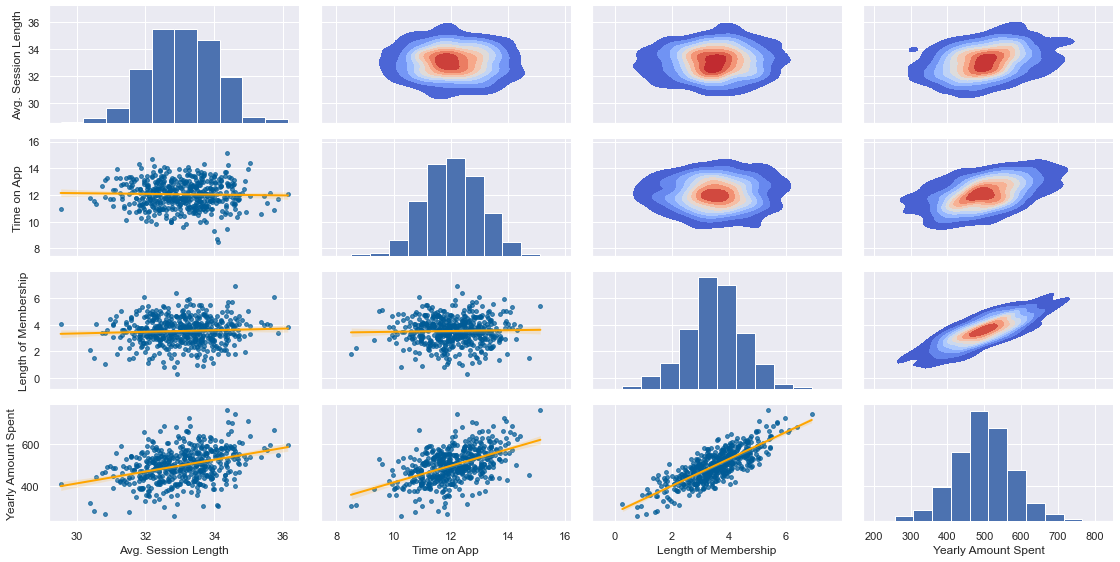

In [44]:
grid = sns.PairGrid(data1, vars=['Avg. Session Length', 'Time on App', 'Length of Membership', 'Yearly Amount Spent'],
                    height=2, aspect = 2)

grid = grid.map_diag(plt.hist)
grid = grid.map_lower(sns.regplot, scatter_kws = {'s': 15, 'alpha': 0.7, 'color': '#005b96'}, 
                      line_kws = {'color':'orange', 'linewidth': 2})
grid = grid.map_upper(sns.kdeplot, n_levels = 10, cmap= 'coolwarm', shade = True)

plt.show()

There is definitely a relationship between our target variable and length of membership and also all of our features and our target variable have a bell shaped curve

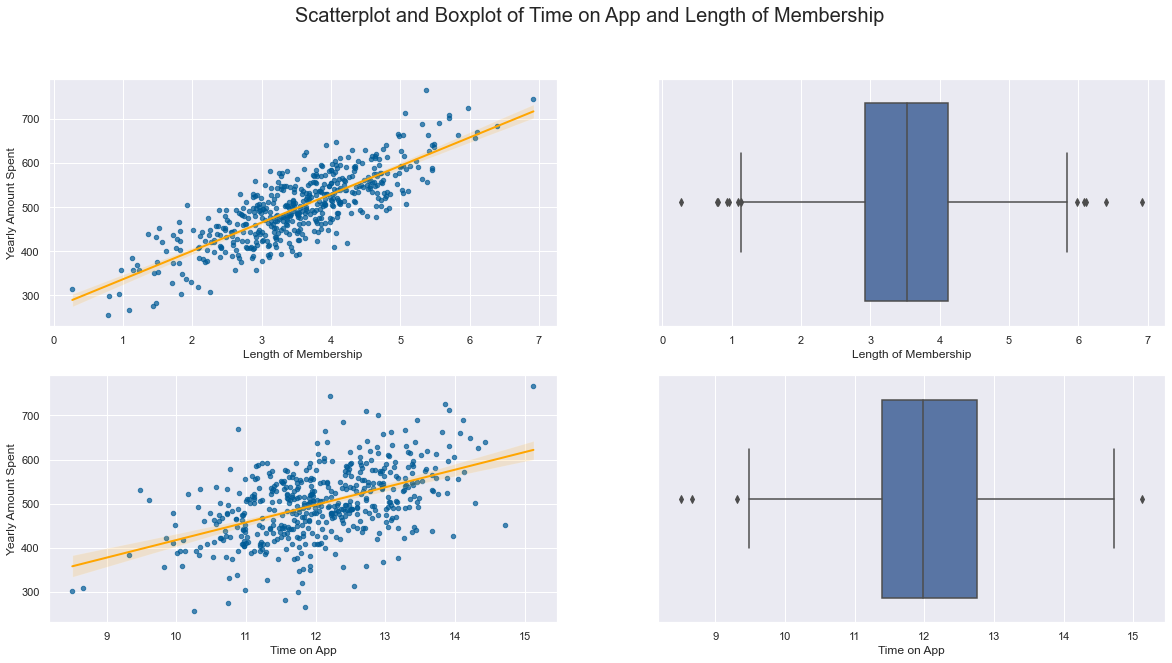

In [45]:
fig, axs = plt.subplots(2, 2, figsize= (20, 10))
fig.suptitle('Scatterplot and Boxplot of Time on App and Length of Membership', fontsize = 20)

sns.regplot(x = data1['Length of Membership'], y= data1['Yearly Amount Spent'], scatter_kws = {'s': 20, 'color': '#005b96', 'alpha': 0.7}, line_kws = {'linewidth': 2, 'color': 'orange'}, ax = axs[0, 0])
sns.boxplot(x = data1['Length of Membership'], ax= axs[0, 1])

sns.regplot(x = data1['Time on App'], y= data1['Yearly Amount Spent'], scatter_kws = {'s': 20, 'color': '#005b96','alpha': 0.7}, line_kws = {'linewidth': 2, 'color': 'orange'}, ax = axs[1, 0])
sns.boxplot(x = data1['Time on App'], ax= axs[1, 1])

plt.show()

In [46]:
data2 = data1.copy()

## **Scaling and Splitting**

In [47]:
X = data2.drop(['Yearly Amount Spent'], axis=1)
y = data2['Yearly Amount Spent']

In [48]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

## **Hyperparameter optimization**

In [50]:
kf = KFold(n_splits= 5)

In [51]:
def random_forest_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    bootstrap = trial.suggest_categorical('bootstrap', ['True', 'False'])

    model = RandomForestRegressor(
        n_estimators= n_estimators,
        max_depth= max_depth,
        bootstrap= bootstrap
    )

    model.fit(X_train, y_train)
    cv_score = - cross_val_score(model, X_train, y_train, scoring= 'neg_mean_squared_error', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'minimize')
study.optimize(random_forest_objective, n_trials= 10)

[I 2022-10-01 15:09:15,472] A new study created in memory with name: no-name-196df53f-b7d4-4c64-b2bb-374df4bbe9ce
[I 2022-10-01 15:09:20,232] Trial 0 finished with value: 353.31681780127167 and parameters: {'n_estimators': 263, 'max_depth': 27, 'bootstrap': 'False'}. Best is trial 0 with value: 353.31681780127167.
[I 2022-10-01 15:09:26,106] Trial 1 finished with value: 351.03523462570524 and parameters: {'n_estimators': 316, 'max_depth': 17, 'bootstrap': 'True'}. Best is trial 1 with value: 351.03523462570524.
[I 2022-10-01 15:09:31,871] Trial 2 finished with value: 451.40888478179977 and parameters: {'n_estimators': 355, 'max_depth': 6, 'bootstrap': 'True'}. Best is trial 1 with value: 351.03523462570524.
[I 2022-10-01 15:09:38,509] Trial 3 finished with value: 357.99925573547654 and parameters: {'n_estimators': 355, 'max_depth': 47, 'bootstrap': 'True'}. Best is trial 1 with value: 351.03523462570524.
[I 2022-10-01 15:09:40,564] Trial 4 finished with value: 351.79388135801884 and pa

In [52]:
def catboost_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0, 0.5)
    iterations = trial.suggest_int('iterations', 50, 300)
    depth = trial.suggest_int('depth', 3, 10)

    model = CatBoostRegressor(
        learning_rate= learning_rate,
        iterations= iterations,
        depth= depth,
        verbose= 0
    )

    model.fit(X_train, y_train)
    cv_score = - cross_val_score(model, X_train, y_train, scoring= 'neg_mean_squared_error', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'minimize')
study.optimize(catboost_objective, n_trials= 10)

[I 2022-10-01 15:10:04,109] A new study created in memory with name: no-name-8c6251e9-bf32-4bfe-81c7-e46534e35484
[I 2022-10-01 15:10:05,512] Trial 0 finished with value: 178.04111948607448 and parameters: {'learning_rate': 0.19783091726415541, 'iterations': 82, 'depth': 4}. Best is trial 0 with value: 178.04111948607448.
[I 2022-10-01 15:10:13,471] Trial 1 finished with value: 411.9018481883321 and parameters: {'learning_rate': 0.422635301817595, 'iterations': 123, 'depth': 9}. Best is trial 0 with value: 178.04111948607448.
[I 2022-10-01 15:10:16,283] Trial 2 finished with value: 183.6915630974404 and parameters: {'learning_rate': 0.26347524319025806, 'iterations': 296, 'depth': 4}. Best is trial 0 with value: 178.04111948607448.
[I 2022-10-01 15:10:19,889] Trial 3 finished with value: 351.8513803030822 and parameters: {'learning_rate': 0.03609331023165052, 'iterations': 156, 'depth': 7}. Best is trial 0 with value: 178.04111948607448.
[I 2022-10-01 15:10:28,307] Trial 4 finished wit

In [53]:
def ridge_objective(trial):
    tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
    alpha = trial.suggest_float('alpha', 0, 1)

    model = Ridge(
        tol= tol,
        alpha= alpha
    )

    model.fit(X_train, y_train)
    cv_score = - cross_val_score(model, X_train, y_train, scoring= 'neg_mean_squared_error', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'minimize')
study.optimize(ridge_objective, n_trials= 10)

[I 2022-10-01 15:11:17,523] A new study created in memory with name: no-name-7f7494b2-00a8-4c82-8624-da77766c0694
[I 2022-10-01 15:11:17,605] Trial 0 finished with value: 98.41924799048499 and parameters: {'tol': 0.00154830159454611, 'alpha': 0.25711831400933083}. Best is trial 0 with value: 98.41924799048499.
[I 2022-10-01 15:11:17,621] Trial 1 finished with value: 98.41722043416284 and parameters: {'tol': 0.0017092756958127127, 'alpha': 0.10614631899073712}. Best is trial 1 with value: 98.41722043416284.
[I 2022-10-01 15:11:17,637] Trial 2 finished with value: 98.41720139655433 and parameters: {'tol': 1.8208117500288134e-06, 'alpha': 0.10236252365777043}. Best is trial 2 with value: 98.41720139655433.
[I 2022-10-01 15:11:17,653] Trial 3 finished with value: 98.42921291668156 and parameters: {'tol': 0.0017818358631896947, 'alpha': 0.5307555808339995}. Best is trial 2 with value: 98.41720139655433.
[I 2022-10-01 15:11:17,669] Trial 4 finished with value: 98.42062279991444 and parameter

In [55]:
def lasso_objective(trial):
    tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
    alpha = trial.suggest_float('alpha', 0, 1)

    model = Lasso(
        tol= tol,
        alpha= alpha
    )

    model.fit(X_train, y_train)
    cv_score = - cross_val_score(model, X_train, y_train, scoring= 'neg_mean_squared_error', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'minimize')
study.optimize(lasso_objective, n_trials= 10)

[I 2022-10-01 15:11:46,904] A new study created in memory with name: no-name-7b452f2c-d101-4869-862f-94f16e5af280
[I 2022-10-01 15:11:46,928] Trial 0 finished with value: 100.35975333867034 and parameters: {'tol': 1.056346458309951e-06, 'alpha': 0.8253497848147254}. Best is trial 0 with value: 100.35975333867034.
[I 2022-10-01 15:11:46,941] Trial 1 finished with value: 101.00725486877457 and parameters: {'tol': 0.0005862842103467059, 'alpha': 0.9515305723445278}. Best is trial 0 with value: 100.35975333867034.
[I 2022-10-01 15:11:46,953] Trial 2 finished with value: 99.19520539644626 and parameters: {'tol': 0.07279749949517357, 'alpha': 0.5914781339487793}. Best is trial 2 with value: 99.19520539644626.
[I 2022-10-01 15:11:46,969] Trial 3 finished with value: 101.23586975007508 and parameters: {'tol': 0.01864479563764619, 'alpha': 0.992491058979065}. Best is trial 2 with value: 99.19520539644626.
[I 2022-10-01 15:11:46,980] Trial 4 finished with value: 99.4758551853489 and parameters: 

In [56]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    leaf_size = trial.suggest_int('leaf_size', 1, 50)

    model = KNeighborsRegressor(
        n_neighbors= n_neighbors,
        leaf_size= leaf_size
    )

    model.fit(X_train, y_train)
    cv_score = - cross_val_score(model, X_train, y_train, scoring= 'neg_mean_squared_error', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'minimize')
study.optimize(knn_objective, n_trials= 10)

[I 2022-10-01 15:12:11,900] A new study created in memory with name: no-name-07a09907-8e84-4506-a50a-4d55356e0131
[I 2022-10-01 15:12:11,926] Trial 0 finished with value: 425.6050484132579 and parameters: {'n_neighbors': 4, 'leaf_size': 50}. Best is trial 0 with value: 425.6050484132579.
[I 2022-10-01 15:12:11,939] Trial 1 finished with value: 702.2045065123122 and parameters: {'n_neighbors': 17, 'leaf_size': 5}. Best is trial 0 with value: 425.6050484132579.
[I 2022-10-01 15:12:11,949] Trial 2 finished with value: 525.3913904334229 and parameters: {'n_neighbors': 8, 'leaf_size': 40}. Best is trial 0 with value: 425.6050484132579.
[I 2022-10-01 15:12:11,960] Trial 3 finished with value: 614.4159743887241 and parameters: {'n_neighbors': 12, 'leaf_size': 32}. Best is trial 0 with value: 425.6050484132579.
[I 2022-10-01 15:12:11,972] Trial 4 finished with value: 525.3913904334229 and parameters: {'n_neighbors': 8, 'leaf_size': 5}. Best is trial 0 with value: 425.6050484132579.
[I 2022-10-

In [58]:
random_forest_params = {
    'n_estimators': 479, 
    'max_depth': 18, 
    'bootstrap': 'False'
}

catboost_params = {
    'learning_rate': 0.09283646947015993, 
    'iterations': 286, 
    'depth': 3,
    'verbose': 0
}

ridge_params = {
    'tol': 2.6773399620833603e-07, 
    'alpha': 0.058158941739886394
}

lasso_params = {
    'tol': 0.0748529183574545, 
    'alpha': 0.03140815868349302
}

knn_params = {
    'n_neighbors': 4, 
    'leaf_size': 33
}


## **Modelling**

In [59]:
models = {
    'random forest': RandomForestRegressor(**random_forest_params),
    'catboost' : CatBoostRegressor(**catboost_params),
    'ridge' : Ridge(**ridge_params),
    'lasso' : Lasso(**lasso_params),
    'knn' : KNeighborsRegressor(**knn_params)
}

In [60]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained")
    

random forest trained
catboost trained
ridge trained
lasso trained
knn trained


## **Evaluation**

In [61]:
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf))
    results[name] = result

In [62]:
for name, result in results.items():
    print("-------\n" + name)
    print(np.mean(result))
    print(np.std(result))

-------
random forest
18.505547741216514
2.9976883994517816
-------
catboost
12.722068315071883
1.0615927682094657
-------
ridge
9.838427779101284
0.9720939474624083
-------
lasso
9.834160279463012
0.9704192428457076
-------
knn
19.774600170956752
3.6143911885792286


Clearly, ridge and lasso along with catboost seems to be performing the best. So we will combine these 3 to predict final results

## **Final Predictions**

In [63]:
final_predictions = (
    0.2 * models['catboost'].predict(X_test) +
    0.4 * models['ridge'].predict(X_test) +
    0.4 * models['lasso'].predict(X_test) 
)

In [64]:
r2 = r2_score(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print("RMSE:", rmse)
print("R-square:", r2)

RMSE: 10.527443162303632
R-square: 0.9776185211758321


We have an R-Square of 0.977, which is very close to 1. Therefore, our model is doing a very good job. Let us also visualise the final results

## **Visualising results**

0.41

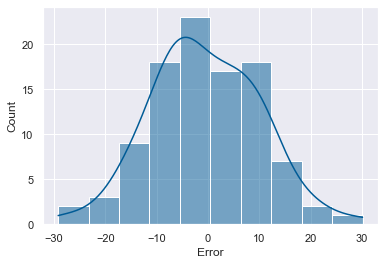

In [65]:
# Distribution of error
sns.histplot(y_test - final_predictions, color = '#005b96', kde= True)
plt.xlabel('Error')
normaltest(final_predictions).pvalue.round(3)

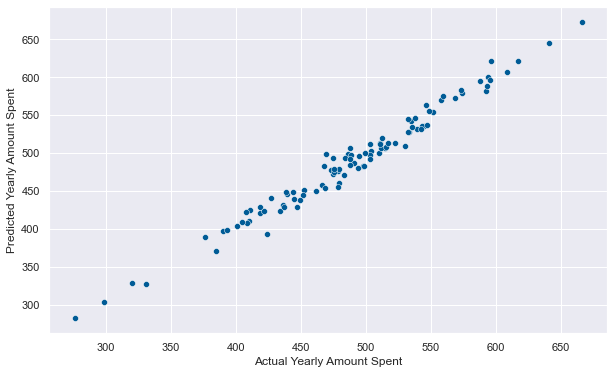

In [66]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual Yearly Amount Spent')
plt.ylabel('Predicted Yearly Amount Spent')
plt.show()

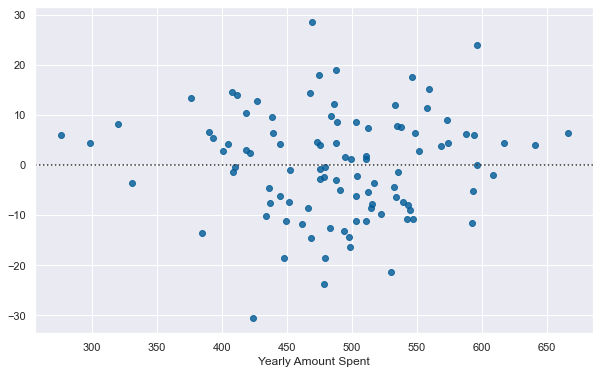

In [67]:
plt.figure(figsize= (10, 6))
sns.residplot(x= y_test, y = final_predictions, color= '#005b96')
plt.show()

## **ANN**

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(80, activation = 'relu'),
    tf.keras.layers.Dense(80, activation = 'relu'),
    tf.keras.layers.Dense(80, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(
    loss = tf.keras.losses.mae,
    optimizer = 'adam',
    metrics = 'mae'
)

history = model.fit(X_train, y_train, validation_split = 0.10, epochs = 100)

Epoch 1/100
12/12 [==============================] - 0s 12ms/step - loss: 502.0629 - mae: 502.0629 - val_loss: 497.4916 - val_mae: 497.4916
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 500.7982 - mae: 500.7982 - val_loss: 495.4580 - val_mae: 495.4580
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 497.6338 - mae: 497.6338 - val_loss: 490.1129 - val_mae: 490.1129
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 489.8180 - mae: 489.8180 - val_loss: 477.6733 - val_mae: 477.6733
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 472.3302 - mae: 472.3302 - val_loss: 451.1887 - val_mae: 451.1887
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 437.1599 - mae: 437.1599 - val_loss: 399.8509 - val_mae: 399.8509
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 371.6933 - mae: 371.6933 - val_loss: 308.9920 - val_mae: 308.9920
Epoch 8/100
12/12 [=======

In [75]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

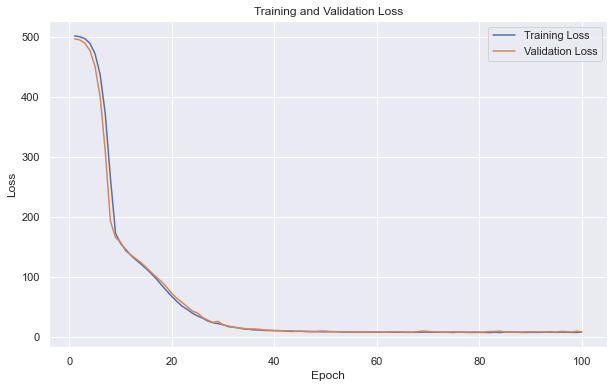

In [82]:
plt.figure(figsize=(10, 6))

epochs = range(1, 101)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [84]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 8.9379 - mae: 8.9379


[8.937858581542969, 8.937858581542969]

In [85]:
y_pred = model.predict(X_test)

In [86]:
print('R-square:', r2_score(y_test, y_pred))

R-square: 0.97554181261684


We have an R-square of 0.975, so our Artificial neural network is also doing a pretty good job